# BayesWaveAnalysis.ipynb

### Given Bayeswave parameter estimation results, plot the median waveforms and evidences

Maria Okounkova (mokounkova@flatironinstitute.org)

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import sys
import h5py
import os
import seaborn as sns
import matplotlib.gridspec as gridspec
from math import sqrt

from ipynb.fs.full.Auxiliary import SubtractPeakTime, EllinKm, ComputeOverlap, ComputeMultiDetectorOverlap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

#rc('text', usetex=True)
# Plot parameters
#matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# matplotlib.rcParams['axes.labelsize'] = 24
# matplotlib.rcParams['xtick.labelsize'] = 30
# matplotlib.rcParams['ytick.labelsize'] = 30
# matplotlib.rcParams['xtick.major.size'] = 20
# matplotlib.rcParams['ytick.major.size'] = 20
# matplotlib.rcParams['xtick.top'] = True
# matplotlib.rcParams['xtick.direction'] = 'in'
# matplotlib.rcParams['xtick.minor.visible'] = True
# matplotlib.rcParams['xtick.minor.size'] = 10
# matplotlib.rcParams['ytick.minor.size'] = 10
# matplotlib.rcParams['legend.fontsize'] = 18
# matplotlib.rcParams['legend.frameon'] = True
#matplotlib.rcParams['lines.linewidth'] = 3

t_gps = 1126259462.0
t_start = t_gps - 2.0

## Data reading methods

In [110]:
def GetBWDir(p):
    return p + '/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/'

def GetBWMedianData(p, det = "H1"):
    """ Given a BW run directory and a detector, read in the median time domain waveform 
        and confidence intervals """
    
    base_dir = GetBWDir(p)
 
    ## Grab Livingston data
    f = base_dir + "post/signal/signal_median_time_domain_waveform_" + det + ".dat"
    time, d1, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    
    time = time + t_start
    return time, d1, d2, d3, d4, d5

def GetBWInjectedData(p, det = "H1"):
    """ Given a BW run directory and a detector, read in the injected time domain waveform """
    
    base_dir = GetBWDir(p)
    
    f = base_dir + 'post/whitened_data_' + det + '.dat'
    data = np.loadtxt(f)
    
    ## Compute the corresponding time array 
    s_rate = 2048
    dt = 1.0/s_rate
    time = np.array([dt * t for t in range(len(data))])
 
    time = time + t_start
    return time, data

def GetBilbyData(p, det = "H1"):
    """ Given a directory, grab that whitened Bilby waveforms """
    bilby_p = p + '/LI_reconstruct/'
    time, MAP = np.loadtxt(bilby_p + det + '_summary_waveforms_samples.dat', \
        comments="#",usecols=([0,2]),unpack=True)
    return time, MAP

def GetBWFrequencyDomainWaveform(p, detector):
    """ 
    Given a BW run directory and a detector, read in the recovered BW freq domain waveform
    
    Ignore the first column, it's wrong. The second line is the median with alternating real and imaginary waveforms
    The first line is h_R at f=0, the second line is h_I at f=0 etc """
    
    base_dir = GetBWDir(p)
 
    f = base_dir + "post/signal/signal_median_frequency_domain_waveform_" \
                                                               + detector + ".dat"
    freq, d1, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    length = len(freq)
    
    ## Grab the true frequency range
    freq = freq[0:int(length/2)]
    
    ## Now split up the median into real and imaginary parts
    d1 = d1[0::2] + 1j*d1[1::2]
    d2 = d2[0::2] + 1j*d2[1::2]
    d3 = d3[0::2] + 1j*d3[1::2]
    d4 = d4[0::2] + 1j*d4[1::2]
    d5 = d5[0::2] + 1j*d5[1::2]
    return freq, d1, d2, d3, d4, d5

def GetBWInjectedFrequencyDomainWaveform(p, detector):
    """ 
    Given a BW run directory and a detector, read in the injected BW freq domain waveform
    
    Get the injected frequency domain waveform from the same
    place that megaplot.py gets it from. See lines 541 - 543 of
    megaplot.py in plot_full_spectro() method """

    base_dir = GetBWDir(p)
 
    f = base_dir + "waveforms/fourier_domain_data_" + detector + ".dat"
    freq, re, im = np.loadtxt(f, comments="#",usecols=([0,1,2]),unpack=True)
    return freq, re + 1j*im   

## Plot reconstructions

### Plot Bilby and Bayeswave data in same panel

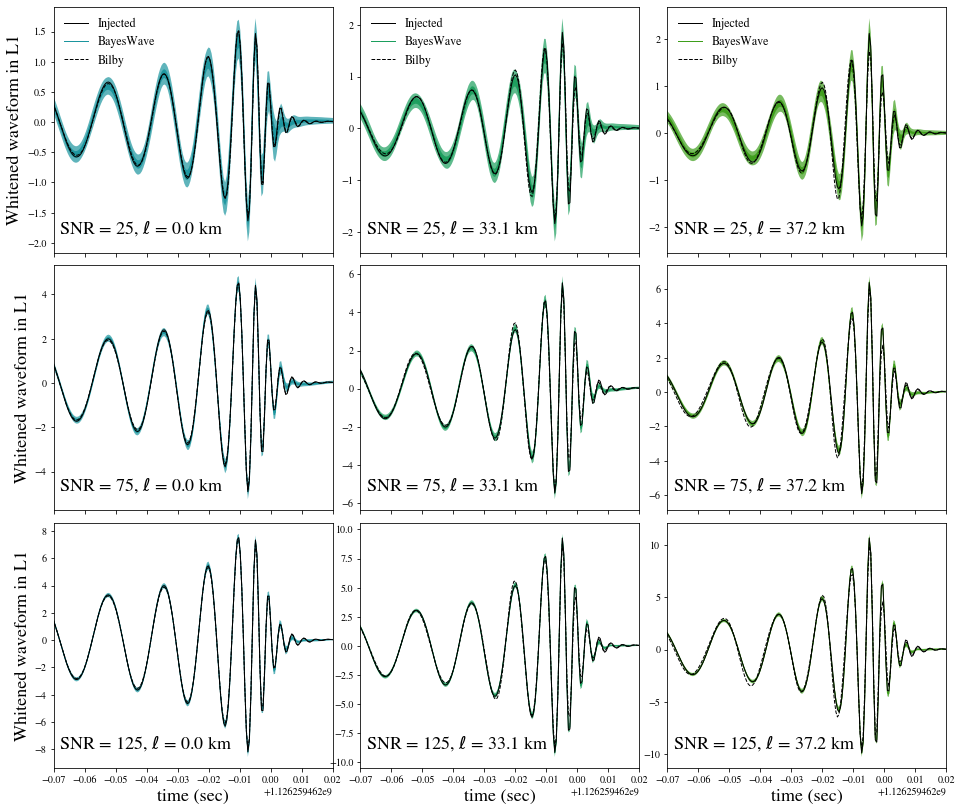

In [111]:
def PlotMedianData(p, ax, color, det = "H1", label = "", legend = False):
    """ Given a directory and an axis, plot BW median recovered 
        and injected data """
    
    ## Bayeswave data
    time, d1, d2, d3, d4, d5 = GetBWMedianData(p, det = det)
    
    ax.plot(time, d1, '-', lw = 1.0, alpha = 1.0, color=color, label = 'BayesWave')  
    ax.fill_between(time, d2, d3, alpha = 0.9, color=color, edgecolor=None)
    ax.fill_between(time, d4, d5, alpha = 0.7, color=color, edgecolor=None)
    
    ## Plot injected data 
    time, data = GetBWInjectedData(p, det = det)
    ## Plot empty because we're going to plot
    ax.plot(time, data, '-', color='black', lw = 1.0, alpha=1.0,  label = 'Injected')
    
    ## Plot Bilby reconstruction
    time, data = GetBilbyData(p, det = det)
    ax.plot(time, data, '--', color='black', lw = 1.0, alpha=1.0,  label = 'Bilby')
    
    ## Label ell and SNR
    ax.text(0.02, 0.1, label, horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes, fontsize=18)
    
    ax.set_xlim(t_gps - 0.07, t_gps + 0.02)
    #if legend:
    #    ax.legend(frameon=False, fontsize=12, loc='upper left')
    
    ax.tick_params(axis='x', which='both', bottom=True, top=False) 
    
    if legend:
        # get handles and labels
        handles, labels = ax.get_legend_handles_labels()

        # specify order of items in legend
        order = [1,0,2]

        # add legend to plot
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, fontsize=12, loc='upper left')


def BWPlots():
    """ Create a plot of injected and recovered BW strains in the time domain """
    
    det = "L1"
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_"
    
    fig, axarr = plt.subplots(3,3, figsize=(16, 14), sharex=True, sharey=False)

    mass = 68.0 ## Injected mass

    ell = "0p0"
    color = '#1b959e'
    PlotMedianData(base_dir + "dCS_" + ell + "_25", axarr[0][0], color, det = det, \
                   label = r'SNR = 25, $\ell$ = %.1f km' % EllinKm(ell, mass), legend = True)
    PlotMedianData(base_dir + "dCS_" + ell + "_75", axarr[1][0], color, det = det, \
                   label = r'SNR = 75, $\ell$ = %.1f km' % EllinKm(ell, mass))
    PlotMedianData(base_dir + "dCS_" + ell + "_125", axarr[2][0], color, det = det, \
                   label = r'SNR = 125, $\ell$ = %.1f km' % EllinKm(ell, mass))

    ell = "0p33"
    color = "#1b9e5d"
    PlotMedianData(base_dir + "dCS_" + ell + "_25", axarr[0][1], color, det = det, \
                    label = r'SNR = 25, $\ell$ = %.1f km' % EllinKm(ell, mass), legend = True)
    PlotMedianData(base_dir + "dCS_" + ell + "_75", axarr[1][1], color, det = det, \
                   label = r'SNR = 75, $\ell$ = %.1f km' % EllinKm(ell, mass))
    PlotMedianData(base_dir + "dCS_" + ell + "_125", axarr[2][1], color, det = det, \
                   label = r'SNR = 125, $\ell$ = %.1f km' % EllinKm(ell, mass))
    
    ell = "0p37"
    color = "#3e9e1b"
    PlotMedianData(base_dir + "dCS_" + ell + "_25", axarr[0][2], color, det = det, \
                    label = r'SNR = 25, $\ell$ = %.1f km' % EllinKm(ell, mass), legend = True)
    PlotMedianData(base_dir + "dCS_" + ell + "_75", axarr[1][2], color, det = det, \
                   label = r'SNR = 75, $\ell$ = %.1f km' % EllinKm(ell, mass))
    PlotMedianData(base_dir + "dCS_" + ell + "_125", axarr[2][2], color, det = det, \
                   label = r'SNR = 125, $\ell$ = %.1f km' % EllinKm(ell, mass))

    for i in range(3):
        axarr[-1][i].set_xlabel('time (sec)', fontsize = 18)
        axarr[i][0].set_ylabel('Whitened waveform in ' + det, ha='center', labelpad = 4.0, rotation='vertical', fontsize=18)
    plt.subplots_adjust(wspace=0.1, hspace=0.05)
    #fig.text(0.06, 0.5, 'Whitened waveform in ' + det, ha='center', va='center', rotation='vertical', fontsize=18)
    plt.savefig('Bayeswave.pdf')
    #plt.tight_layout()
    plt.show()

BWPlots()

### Plot reconstructions with insets for Bilby data

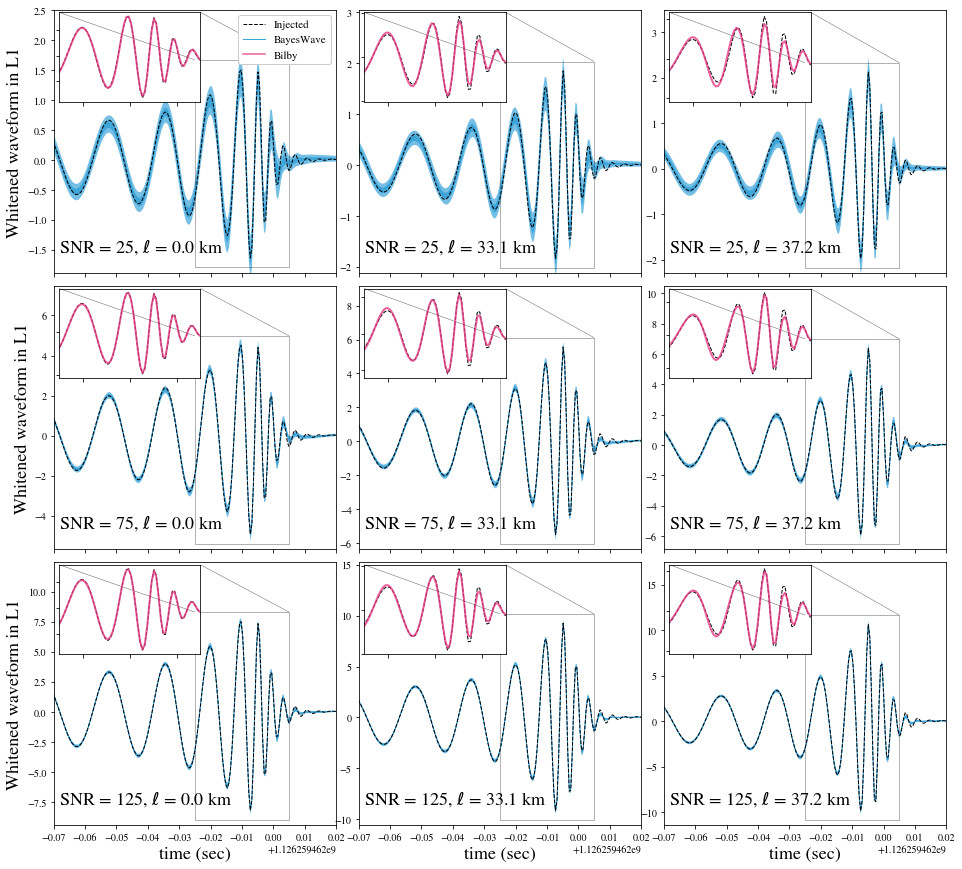

In [137]:
def PlotMedianDataInset(p, ax, det = "H1", label = "", legend = False):
    """ Given a directory and an axis, plot BW median recovered 
        and injected data """
    
    ## Bayeswave data
    time, d1, d2, d3, d4, d5 = GetBWMedianData(p, det = det)
    bw_color = "#3ba4d9"
    
    ax.plot(time, d1, '-', lw = 1.0, alpha = 1.0, color=bw_color, label = 'BayesWave')  
    ax.fill_between(time, d2, d3, alpha = 0.9, color=bw_color, edgecolor=None)
    ax.fill_between(time, d4, d5, alpha = 0.7, color=bw_color, edgecolor=None)
    
    ## Plot injected data 
    time, data = GetBWInjectedData(p, det = det)
    ax.plot(time, data, '--', color='black', lw = 1.0, alpha=1.0,  label = 'Injected')
    
    ## Plot Bilby reconstruction
    bilby_color = '#e63984'
    time_bilby, data_bilby = GetBilbyData(p, det = det)
    ax.plot([],[], '-', color = bilby_color, lw = 1.5, alpha=0.8,  label = 'Bilby')

    
    axins = ax.inset_axes([0.02, 0.65, 0.5, 0.34])
    axins.plot(time, data, '--', color = 'black', lw = 1.0, alpha = 1.0)
    axins.plot(time_bilby, data_bilby, '-', color = bilby_color, lw = 2.0, alpha = 0.8, label = 'Bilby') 
    
    # sub region of the original image
    y_lo, y_hi = axins.get_ylim()
    ax.set_ylim(y_lo*1.05, y_hi*1.5)
    axins.set_xlim(t_gps - 0.025, t_gps + 0.005)
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec="black", alpha = 0.6, lw = 0.5)
    
    ## Label ell and SNR
    ax.text(0.02, 0.1, label, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    ax.set_xlim(t_gps - 0.07, t_gps + 0.02)
    
    if legend:
        # get handles and labels
        handles, labels = ax.get_legend_handles_labels()
        # specify order of items in legend
        order = [1,0,2]
        # add legend to plot
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=True, framealpha = 1.0, fontsize=11, loc='upper right')


def PlotInsets():
    """ Create a plot of injected and recovered BW strains in the time domain """
    
    det = "L1"
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_"
    
    fig, axarr = plt.subplots(3,3, figsize=(16, 15), sharex=True, sharey=False)

    mass = 68.0 ## Injected mass

    ell = "0p0"
    PlotMedianDataInset(base_dir + "dCS_" + ell + "_25", axarr[0][0], det = det, \
                   label = r'SNR = 25, $\ell$ = %.1f km' % EllinKm(ell, mass), legend = True)
    PlotMedianDataInset(base_dir + "dCS_" + ell + "_75", axarr[1][0], det = det, \
                   label = r'SNR = 75, $\ell$ = %.1f km' % EllinKm(ell, mass))
    PlotMedianDataInset(base_dir + "dCS_" + ell + "_125", axarr[2][0], det = det, \
                   label = r'SNR = 125, $\ell$ = %.1f km' % EllinKm(ell, mass))

    ell = "0p33"
    PlotMedianDataInset(base_dir + "dCS_" + ell + "_25", axarr[0][1], det = det, \
                   label = r'SNR = 25, $\ell$ = %.1f km' % EllinKm(ell, mass))
    PlotMedianDataInset(base_dir + "dCS_" + ell + "_75", axarr[1][1], det = det, \
                   label = r'SNR = 75, $\ell$ = %.1f km' % EllinKm(ell, mass))
    PlotMedianDataInset(base_dir + "dCS_" + ell + "_125", axarr[2][1], det = det, \
                   label = r'SNR = 125, $\ell$ = %.1f km' % EllinKm(ell, mass))
    
    ell = "0p37"
    PlotMedianDataInset(base_dir + "dCS_" + ell + "_25", axarr[0][2], det = det, \
                    label = r'SNR = 25, $\ell$ = %.1f km' % EllinKm(ell, mass))
    PlotMedianDataInset(base_dir + "dCS_" + ell + "_75", axarr[1][2], det = det, \
                   label = r'SNR = 75, $\ell$ = %.1f km' % EllinKm(ell, mass))
    PlotMedianDataInset(base_dir + "dCS_" + ell + "_125", axarr[2][2], det = det, \
                   label = r'SNR = 125, $\ell$ = %.1f km' % EllinKm(ell, mass))

    for i in range(3):
        axarr[-1][i].set_xlabel('time (sec)', fontsize = 18)
        axarr[i][0].set_ylabel('Whitened waveform in ' + det, ha='center', labelpad = 4.0, rotation='vertical', fontsize=18)
    plt.subplots_adjust(wspace=0.08, hspace=0.05)
    plt.savefig('Reconstructions.pdf')
    #plt.tight_layout()
    plt.show()

PlotInsets()

### Reconstructions with separate BayesWave and Bilby Pannels

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


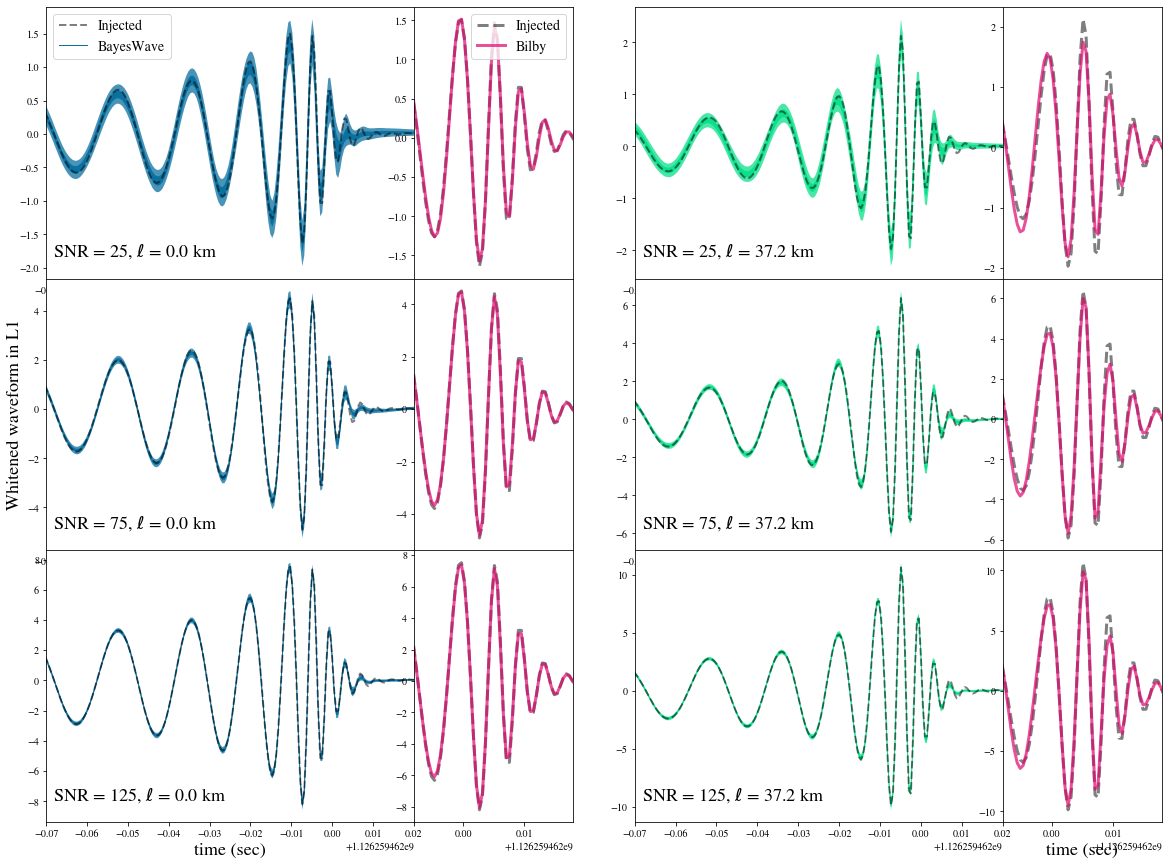

In [66]:
def PlotReconData(p, ax1, ax2, color, det = "H1", label = "", legend = False):
    """ Given a directory and an axis, plot BW median recovered 
        and injected data """
    
    ## Bayeswave data
    time, d1, d2, d3, d4, d5 = GetBWMedianData(p, det = det)
    
    ax1.plot(time, d1, '-', lw = 1.0, alpha = 1.0, color=color, label = 'BayesWave')  
    ax1.fill_between(time, d2, d3, alpha = 1.0, color=color, edgecolor=None)
    ax1.fill_between(time, d4, d5, alpha = 0.75, color=color, edgecolor=None)
    
    ## Plot injected data 
    time, data = GetBWInjectedData(p, det = det)
    ax1.plot(time, data, '--', color='black', lw = 2.0, alpha=0.5,  label = 'Injected')
    ax2.plot(time, data, '--', color='black', lw = 3.0, alpha=0.5, label = 'Injected')
    
    ## Plot Bilby reconstruction
    time, data = GetBilbyData(p, det = det)
    bilby_color = '#de076f'
    bilby_ls = '-'
    #ax1.plot(time, data, bilby_ls, color=bilby_color, lw = 1.0, alpha=1.0,  label = 'Bilby')
    ax2.plot(time, data, bilby_ls, color=bilby_color, lw = 3.0, alpha=0.7, label = 'Bilby')
    
    ## Label ell and SNR
    ax1.text(0.02, 0.1, label, horizontalalignment='left',
     verticalalignment='center', transform=ax1.transAxes, fontsize=18)
    
    ax1.set_xlim(t_gps - 0.07, t_gps + 0.02)
    ax2.set_xlim(t_gps - 0.018, t_gps + 0.008)
    
    #ax.tick_params(axis='x', which='both', bottom=True, top=False) 

    if legend:
        # get handles and labels
        handles, labels = ax1.get_legend_handles_labels()

        # specify order of items in legend
        order = [1,0]

        # add legend to plot
        ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=True, fontsize=14, loc='upper left')
        ax2.legend(frameon=True, fontsize=14, loc='upper right')


def PanelPlots():
    """ Create a plot of injected and recovered BW strains in the time domain """
    
    det = "L1"
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_"
    
    fig = plt.figure(figsize=(20, 15))
    
    gs = gridspec.GridSpec(3, 5, width_ratios=[3, 1.3, 0.5, 3,1.3], height_ratios=[1,1,1])
    gs.update(wspace=0.0, hspace=0.0)
              
    ax_arr = np.zeros((3, 4))
    print(ax_arr)
    ax_arr[0][0] = plt.subplot(gs[0])
    ax_arr[0][1] = plt.subplot(gs[1])
    ax_arr[0][2] = plt.subplot(gs[3])
    ax_arr[0][3] = plt.subplot(gs[4])
    
    ax_arr10 = plt.subplot(gs[5])
    ax_arr11 = plt.subplot(gs[6])
    ax_arr12 = plt.subplot(gs[8])
    ax_arr13 = plt.subplot(gs[9])
    
    ax_arr20 = plt.subplot(gs[10])
    ax_arr21 = plt.subplot(gs[11])
    ax_arr22 = plt.subplot(gs[13])
    ax23 = plt.subplot(gs[14])
    
    ## Axis bounds
    lim_25 = 2.1
    #for ax in 
    #ax00.set_ylim(-lim_25, lim_25)
    #ax01.set_ylim(-2.5, 2.1)
    
    ## Fake subplots to create space
    axt0 = plt.subplot(gs[2])
    axt1 = plt.subplot(gs[7])
    axt2 = plt.subplot(gs[12])
    
    for ax in [axt0, axt1, axt2]:
        ax.axis('off')

    mass = 68.0 ## Injected mass

    ell = "0p0"
    color = '#0b71a1'
    PlotReconData(base_dir + "dCS_" + ell + "_25", ax00, ax01, color, det = det, \
                   label = r'SNR = 25, $\ell$ = %.1f km' % EllinKm(ell, mass), legend = True)
    PlotReconData(base_dir + "dCS_" + ell + "_75", ax10, ax11, color, det = det, \
                   label = r'SNR = 75, $\ell$ = %.1f km' % EllinKm(ell, mass), legend = False)
    PlotReconData(base_dir + "dCS_" + ell + "_125", ax20, ax21, color, det = det, \
                   label = r'SNR = 125, $\ell$ = %.1f km' % EllinKm(ell, mass), legend = False)
    
    ell = "0p37"
    color = '#0be08b'
    PlotReconData(base_dir + "dCS_" + ell + "_25", ax02, ax03, color, det = det, \
                   label = r'SNR = 25, $\ell$ = %.1f km' % EllinKm(ell, mass), legend = False)
    PlotReconData(base_dir + "dCS_" + ell + "_75", ax12, ax13, color, det = det, \
                   label = r'SNR = 75, $\ell$ = %.1f km' % EllinKm(ell, mass), legend = False)
    PlotReconData(base_dir + "dCS_" + ell + "_125", ax22, ax23, color, det = det, \
                   label = r'SNR = 125, $\ell$ = %.1f km' % EllinKm(ell, mass), legend = False)


    ax20.set_xlabel('time (sec)', fontsize = 18)
    ax23.set_xlabel('time (sec)', fontsize = 18)
    ax10.set_ylabel('Whitened waveform in ' + det, ha='center', labelpad = 4.0, rotation='vertical', fontsize=18)
    #plt.subplots_adjust(wspace=0.0)
    #fig.text(1.0, 0.5, 'Whitened waveform in ' + det, ha='center', va='center', rotation='vertical', fontsize=18)
    #plt.savefig('Bayeswave.pdf')
    #plt.tight_layout()
    plt.show()

PanelPlots()


## Compute and plot overlaps

/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p0_25/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/overlaps.dat
0p0 25 0.993706
/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p0_75/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/overlaps.dat
0p0 75 0.99864
/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p0_125/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/overlaps.dat
0p0 125 0.999722
/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p3_25/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/overlaps.dat
0p3 25 0.992824
/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p3_75/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/overlaps.dat
0p3 75 0.998519
/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p3_125/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/overlaps.dat
0p3 125 0.99958
/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p33_25/BayesWave/Run/trigtime_1126259462.000000000_

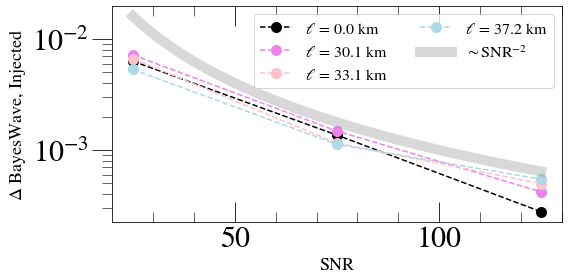

In [29]:
def BayesWaveOverlap(p):
    """ Given a BW run directory p, read in the injected and recovered hs in the 
        time domain and compute an overlap """
    
    ## Check for file with computed multi-detector BW overlap 
    name = GetBWDir(p) + "overlaps.dat"
    print(name)

    if not os.path.isfile(name):
        
        print("Generating overlaps.dat file")
    
        ## Median data and bounds
        t_bw_H1, h_bw_H1, h_bw_2, h_bw_3, h_bw_4, h_bw_5 = GetBWMedianData(p, det = "H1")
        t_bw_L1, h_bw_L1, h_bw_2, h_bw_3, h_bw_4, h_bw_5 = GetBWMedianData(p, det = "L1")
        t_bw_V1, h_bw_V1, h_bw_2, h_bw_3, h_bw_4, h_bw_5 = GetBWMedianData(p, det = "V1")
    
        ## Injected data
        t_inj_H1, h_inj_H1 = GetBWInjectedData(p, det = "H1")
        t_inj_L1, h_inj_L1 = GetBWInjectedData(p, det = "L1")
        t_inj_V1, h_inj_V1 = GetBWInjectedData(p, det = "V1")
    
        overlap_H1 = ComputeOverlap(t_bw_H1, h_bw_H1, t_inj_H1, h_inj_H1)
        overlap_L1 = ComputeOverlap(t_bw_L1, h_bw_L1, t_inj_L1, h_inj_L1)
        overlap_V1 = ComputeOverlap(t_bw_V1, h_bw_V1, t_inj_V1, h_inj_V1)
        
        overlap_all = ComputeMultiDetectorOverlap(t_bw_H1, h_bw_H1, \
                                  t_bw_L1, h_bw_L1, \
                                  t_bw_V1, h_bw_V1, \
                                  t_inj_H1, h_inj_H1, \
                                  t_inj_L1, h_inj_L1, \
                                  t_inj_V1, h_inj_V1)
        
        print('%f %f %f %f' % (overlap_H1, overlap_L1, overlap_V1, overlap_all))
        f_out = open(name, 'w')
        f_out.write('# Overlap between injected and median reconstructed BW waveforms \n # overlap_H1 overlap_L1 overlap_V1 overlap_all \n')
        f_out.write('%f %f %f %f' % (overlap_H1, overlap_L1, overlap_V1, overlap_all))
        f_out.close()
    
    overlap_H1, overlap_L1, overlap_V1, overlap_all = np.loadtxt(name, comments="#",usecols=([0, 1, 2, 3]),unpack=True)
    return overlap_all


# def BayesWaveOverlapFrequency(p):
    
#     """ Given a BW run directory p, read in the injected and recovered strains in the 
#         frequency domain and compute an overlap """
    
#     ## Median data and bounds
#     freq_bw_H1, strain_bw_H1, strain_bw_2, strain_bw_3, strain_bw_4, strain_bw_5 = GetBWFrequencyDomainWaveform(p, "H1")
#     freq_bw_L1, strain_bw_L1, strain_bw_2, strain_bw_3, strain_bw_4, strain_bw_5 = GetBWFrequencyDomainWaveform(p, "L1")
    
#     ## Injected data
#     freq_inj_H1, strain_inj_H1 = GetBWInjectedFrequencyDomainWaveform(p, "H1")
#     freq_inj_L1, strain_inj_L1 = GetBWInjectedFrequencyDomainWaveform(p, "L1")
#     delta_f = freq_inj_L1[1] - freq_inj_L1[0]

#     overlap = ComputeMultiDetectorOverlapFrequency(delta_f, strain_bw_H1, strain_bw_L1, strain_inj_H1, strain_inj_L1)
#     #overlap = ComputeOverlapFrequency(delta_f, strain_bw_H1, strain_inj_H1, psd = True)

#     return overlap
     
def PlotBayesWaveOverlap():
    """ Create a plot of the overlap between BW injected and recovered waveforms as
        a function of SNR. Similar to Fig. 4 in https://arxiv.org/abs/2003.09456 """
    
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_"
    mass = 68

    ells = ["0p0", "0p3", "0p33", "0p37"]
    colors = ['black', 'violet', 'pink', 'lightblue', 'orange', 'red']
    snrs = [25, 75, 125]

    plt.figure(figsize=(8, 4))

    for ell, color in zip(ells, colors):

        delta_arr = []

        for snr in snrs:

            p = base_dir + "dCS_" + ell + "_" + str(snr)
            overlap = BayesWaveOverlap(p)
            print(ell, snr, overlap)
            delta = 1.0 - overlap
            delta_arr.append(delta)

        plt.plot(snrs, delta_arr, '--o', color = color, label = "$\ell$ = %.1f km" % EllinKm(ell, mass), markersize = 10)

    ## Add in 1/SNR^2 curve 
    SNRS = np.linspace(snrs[0], snrs[-1], 100)
    snr_curve = SNRS**-2.0
    plt.plot(SNRS, snr_curve*10, color='gray', label = r'$\sim \mathrm{SNR}^{-2}$', alpha = 0.3, lw = 10.0)

    plt.legend(fontsize=16, ncol=2)
    plt.yscale('log')
    #plt.xscale('log')
    plt.ylabel('$\Delta$ BayesWave, Injected', fontsize=18)
    plt.xlabel('SNR', fontsize=18)
    plt.tight_layout()
    plt.savefig('Deltas.pdf')
    plt.show()
    
PlotBayesWaveOverlap()

## Plot Bilby BayesWave mismatch

25 0p0 0.007000000000000006
25 0p25 0.007000000000000006
25 0p3 0.010000000000000009
25 0p33 0.014000000000000012
25 0p35 0.020000000000000018
25 0p37 0.025000000000000022
75 0p0 0.0010000000000000009
75 0p25 0.0010000000000000009
75 0p3 0.0030000000000000027
75 0p33 0.0040000000000000036
75 0p35 0.007000000000000006
75 0p37 0.009000000000000008
125 0p0 0.0
125 0p25 0.0010000000000000009
125 0p3 0.0010000000000000009
125 0p33 0.0030000000000000027
125 0p35 0.006000000000000005
125 0p37 0.008000000000000007


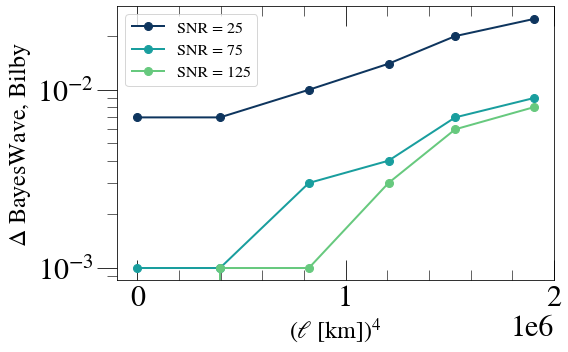

In [28]:
def GetBWLIMismatch(base_dir):
    """ Given a directory, return the mismatch between the bilby reconstructed waveform 
        and the LI waveform from the bw_li_inj.py script results """
    
    file = base_dir + "/bw_li_output/LI_reconstruct/all_stats_overlaps.txt"
    overlap = np.loadtxt(file, comments="#",usecols=([2]),unpack=True, skiprows = 1)
    mismatch = 1 - overlap[-1]
    return mismatch

def PlotBWLIMismatch():
    
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_"
    
    fig = plt.figure(figsize=(8, 5))
    
    ells = ["0p0", "0p25", "0p3", "0p33", "0p35", "0p37"]
    ells_km = np.array([EllinKm(l, 68) for l in ells])**4
    snrs = ['25', '75', '125']
    colors = ["#0e355e", "#199e9e", "#67c97e"]
    #colors = sns.color_palette('gnuplot2', n_colors=len(snrs) + 1)
    
    for snr, color in zip(snrs, colors):
        
        mismatches = []
        
        for ell in ells:
            
            p = base_dir + "dCS_" + ell + "_" + snr
            mismatch = GetBWLIMismatch(p) 
            print(snr, ell, mismatch) 
            mismatches.append(mismatch)

        plt.plot(ells_km, mismatches, '-o', lw = 2.0, markersize=8, color = color, label = 'SNR = ' + snr)
    
    plt.xlabel(r'($\ell$ [km])${}^4$')
    plt.ylabel('$\Delta$ BayesWave, Bilby')
    plt.yscale('log')
    #plt.grid()
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.savefig('BWLIMismatch.pdf') 
    plt.show()
    
PlotBWLIMismatch()

25 0p0 11.879 11.735
25 0p25 11.841 11.706
25 0p3 12.183 11.718
25 0p33 12.149 11.734
25 0p35 11.748 11.739
25 0p37 12.095 11.722
75 0p0 36.666 37.091
75 0p25 35.302 35.904
75 0p3 35.283 35.996
75 0p33 36.52 37.094
75 0p35 35.179 36.165
75 0p37 35.853 37.065
125 0p0 60.943 62.164
125 0p25 60.526 62.152
125 0p3 60.817 62.154
125 0p33 60.45 62.145
125 0p35 60.575 62.138
125 0p37 59.816 62.16


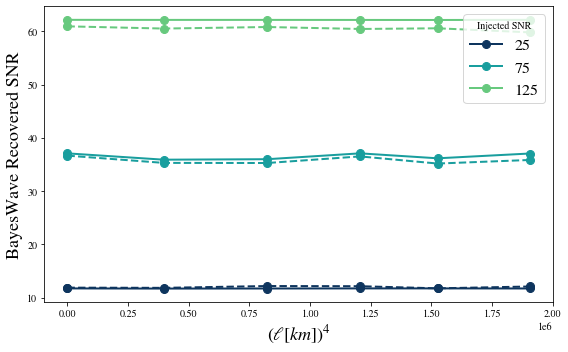

In [17]:
def GetBWSNR(base_dir):
    """ Given a directory, return the mismatch between the bilby reconstructed waveform 
        and the LI waveform from the bw_li_inj.py script results """
    
    file = base_dir + "/bw_li_output/LI_reconstruct/all_stats_overlaps.txt"
    li_snr, bw_snr = np.loadtxt(file, comments="#",usecols=([0, 1]),unpack=True, skiprows = 1)
    return li_snr[0], bw_snr[0]

def PlotBWSNR():
    
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_"
    
    fig = plt.figure(figsize=(8, 5))
    
    ells = ["0p0", "0p25", "0p3", "0p33", "0p35", "0p37"]
    ells_km = np.array([EllinKm(l, 68) for l in ells])**4
    snrs = ['25', '75', '125'] 
    colors = ["#0e355e", "#199e9e", "#67c97e"]
    #colors = sns.color_palette('gnuplot2', n_colors=len(snrs) + 1)
    
    for snr, color in zip(snrs, colors):
        
        bw_snrs = []
        li_snrs = []
        
        for ell in ells:
            
            p = base_dir + "dCS_" + ell + "_" + snr
            li_snr, bw_snr = GetBWSNR(p) 
            print(snr, ell, li_snr, bw_snr) 
            bw_snrs.append(bw_snr)
            li_snrs.append(li_snr)

        plt.plot(ells_km, bw_snrs, '-o', lw = 2.0, markersize=8, color = color, label = snr)
        plt.plot(ells_km, li_snrs, '--o', lw = 2.0, markersize=8, color = color)
    
    plt.xlabel(r'$(\ell [km])^4$', fontsize = 18)
    plt.ylabel('BayesWave Recovered SNR', fontsize = 18)
    #plt.yscale('log')
    plt.legend(fontsize=16, title = 'Injected SNR')
    plt.tight_layout()
    plt.savefig('BWLSNR.pdf') 
    plt.show()
    
PlotBWSNR()

## Plot evidences

1281133.53999 1281134.67429
1281066.9002 1281073.11741
1281033.07737 1281041.44574


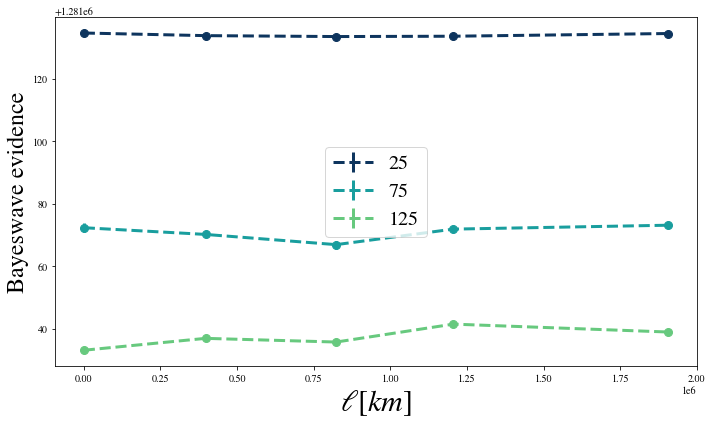

In [21]:
def GetEvidenceTemps(base_dir):
    """ evidence.dat file looks like 
        signal 857281.232665 0.0105919
        glitch 0 0
        noise 0 0
        
        Here we're going to return the (0,1)
        entry, which in this case is 857281.232665
    """
    f = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/' + base_dir + "/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/signal_evidence.dat"
    temp, evidence = np.loadtxt(f, comments="#",usecols=([0, 1]),unpack=True)
    print(len(temp))
    
    return temp, evidence

def GetEvidence(base_dir):
    """ evidence.dat file looks like 
        signal 857281.232665 0.0105919
        glitch 0 0
        noise 0 0
        
        Here we're going to return the (0,1)
        entry, which in this case is 857281.232665
    """
    
    f = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/' + base_dir + "/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/evidence.dat"
 
    ev, variance = np.loadtxt(f, comments="#",usecols=([1, 2]),unpack=True)
    
    ev = ev[0]
    ev_err = sqrt(variance[0])
    
    return ev, ev_err

def PlotBWEvidence():
    
    fig = plt.figure(figsize=(10, 6))
    
    ell = ["0p0", "0p25", "0p3", "0p33", "0p37"]
    ell_km = np.array([EllinKm(l, 68) for l in ell])**4
    snrs = ['25', '75', '125'] 
    colors = ["#0e355e", "#199e9e", "#67c97e"]
    
    for SNR, color in zip(snrs, colors):
    
        BW_Evidence = np.zeros(len(ell))
        BW_Evidence_err = np.zeros(len(ell))

        for i, l in enumerate(ell):
            base_dir = 'PHENOM_dCS_' + l + '_' + SNR
            ev, ev_err = GetEvidence(base_dir) 
            BW_Evidence[i] = ev
            BW_Evidence_err[i] = ev_err
    
        plt.errorbar(ell_km, BW_Evidence, yerr=BW_Evidence_err, linestyle='--', label=SNR, linewidth=3, color = color)
        plt.plot(ell_km, BW_Evidence, 'o', markersize=8, color = color)
        print(min(BW_Evidence), max(BW_Evidence))
    
    plt.xlabel(r'$\ell [km]$', fontsize=30)
    plt.ylabel('Bayeswave evidence')

    plt.legend(fontsize=20)
    plt.tight_layout()
    plt.savefig('BayesWaveEvidence.pdf') 
    plt.show()

PlotBWEvidence()